# Statistical Anomaly Detection

-----

In this IPython Notebook, we introduce the concept of anomaly detection, where one tries to find points or groups of points that do not belong with other points, groups, or clusters of data points. Any point that is affiliated with a group or cluster of _normal_ data is considered an _inlier_ while any point that is not associated with a group or cluster is called an _outlier_. 

One of the most effective ways to identify anomalies is to visually explore the data, which can often indicate statistical approaches that can robustly identify and mitigate the effects of outliers on subsequent analyses. In this Notebook, we explore the use of visualizations and basic statistical tests to identify and remove outlier points from a data set.

-----

## Table of Contents

[Anomaly Detection: Visual Analysis](#Anomaly-Detection:-Visual-Analysis)

[Anomaly Detection: Outlier Types](#Anomaly-Detection:-Outlier-Types)

[Anomaly Detection: Statistical Analysis](#Anomaly-Detection:-Statistical-Analysis)

-----

Before proceeding with the rest of this notebook, we first have our standard notebook setup code.

-----

In [1]:
# Set up Notebook

% matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

# Set global figure properties
import matplotlib as mpl
mpl.rcParams.update({'axes.titlesize' : 20,
                     'axes.labelsize' : 18,
                     'legend.fontsize': 16})

# Set default Seaborn plotting style
sns.set_style('white')

-----
[[Back to TOC]](#Table-of-Contents)

## Anomaly Detection: Visual Analysis

We will begin by visualizing the distribution of the original data. In the first Code cell below, we explore the one-dimensional distribution of each feature in the Iris data set: Sepal Width, Sepal Length, Petal Width, and Petal Length. In the second Code cell, we explore the bi-variate distribution of these data. These visualizations use kernel density estimation, which was covered in an earlier lesson, to generate smooth distributions for both the one- and two-dimensional visualizations.

The goal of these visualizations is to better understand the _expected distribution_ of the data of interest. Without this insight, identifying outliers is considerably more challenging. In some cases, one can construct rules directly from these visualizations to cull or remove many clear and obvious outliers. For example, one might say any data smaller than some constant value is an outlier. Or, we might construct a more complex geometrical bounding box in two (or higher) dimensions. From these figures, we see that the original Iris data are clean. Later in this notebook, we will begin adding different types of outliers or noise into these distributions.

-----

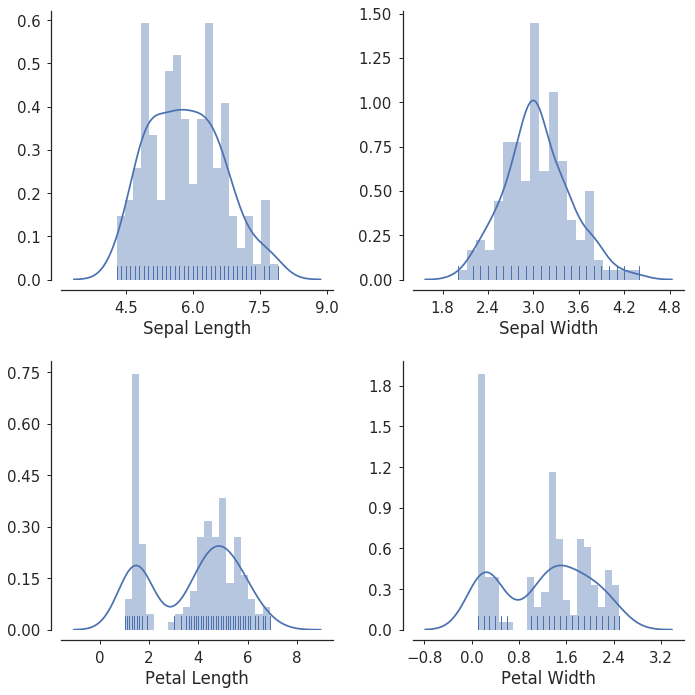

In [2]:
# Grab the iris data, modify column names for pretty plotting
iris = sns.load_dataset('iris')
iris.columns = ['Sepal Length', 'Sepal Width', 
                'Petal Length', 'Petal Width', 'Species']

# Control the figure aesthetics directly.
from matplotlib.ticker import MaxNLocator

# Function to nicely plot a one-dimensional distribution
def plot_oned(data, axs):
    sns.distplot(data, bins=20, kde=True, rug=True, norm_hist=True, ax=axs)
    axs.xaxis.set_major_locator(MaxNLocator(6))
    axs.yaxis.set_major_locator(MaxNLocator(7))
    sns.despine(offset=10)

# Make a box plot to show distributions
sns.set(style='white', font_scale=1.5, 
        rc={'xtick.major.size': 4.0, 'ytick.major.size': 4.0})
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Now plot all four distributions.
plot_oned(iris['Sepal Length'], axs[0][0])
plot_oned(iris['Sepal Width'], axs[0][1])
plot_oned(iris['Petal Length'], axs[1][0])
plot_oned(iris['Petal Width'], axs[1][1])
plt.tight_layout()

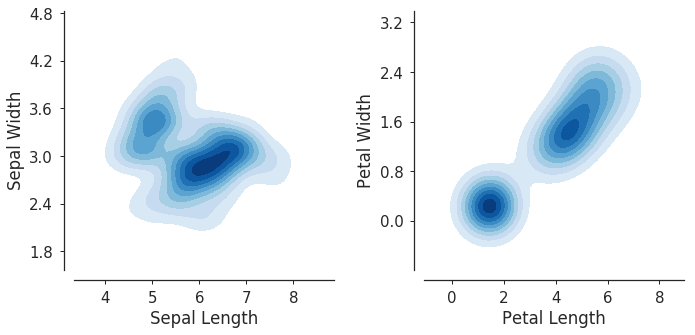

In [3]:
# Plot a two-distribution
def plot_twod(x, y, axs):
    sns.kdeplot(x, y, cmap="Blues", shade=True, shade_lowest=False, ax=axs)
    axs.xaxis.set_major_locator(MaxNLocator(6))
    axs.yaxis.set_major_locator(MaxNLocator(6))
    #axs.set_aspect('equal')
    sns.despine(offset=10)

# Setup the plot and make 2d visualizations
sns.set(style='white', font_scale=1.5, 
        rc={'xtick.major.size': 4.0, 'ytick.major.size': 4.0})
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

plot_twod(iris['Sepal Length'], iris['Sepal Width'], axs[0])
plot_twod(iris['Petal Length'], iris['Petal Width'], axs[1])
plt.tight_layout()


-----
[[Back to TOC]](#Table-of-Contents)

## Anomaly Detection: Outlier Types

At this point, we have repeatedly analyzed the Iris data, and recognize that there are three clear clusters of points (associated with the three Iris types in the sample). These visualizations demonstrate the clear separation of these classes, particularly in the petal measurements. In this notebook, however, we want to identify outlier points, which are not present in the original data. As a result, we now modify the original data to include three different types of outlier points:

1. Extreme values
2. Transposed data
3. Incorrect measurements

Extreme values are points that follow the expected distributions, but have unusually high scatter. We demonstrate these points below (in green) by modeling a feature column as a Gaussian distribution and preferentially sampling high variance points from this model distribution. Second, we simulate possible human error by adding new data points that are existing data points whose columns have simply been transposed (e.g., switching _Sepal Length_ and _Sepal Width_). Finally, incorrect measurements represent data that might be incorrectly obtained or the result of either human or machine error. In this case, we simply change the measurements from centimeters to inches for a sample of data. These new data are displayed, along with the original data, clearly demonstrating the modification to the original distribution.

-----

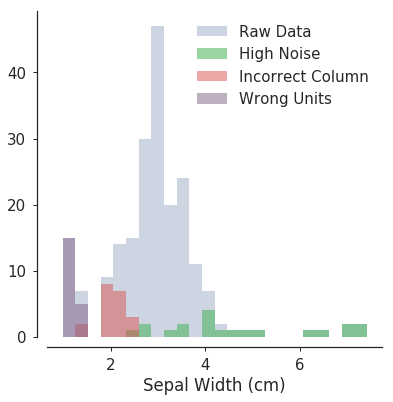

In [4]:
from scipy.stats import uniform

# Model the Sepal Width feature
data = iris['Sepal Width']
mu = np.mean(data)
sig = np.std(data)

# First, we add extreme outliers in Sepal Width
x = np.append(data, (mu - 2.0 * sig) * uniform.rvs(0.9, 1.1, size=10))
x = np.append(x, (mu + 2.0 * sig) * uniform.rvs(0.9, 1.1, size=10))

# Second, we add Petal Width features to the Sepal Width feature
x = np.append(x, iris['Petal Width'][-20:], axis=0)

# Finally, we convert units on some instances (cm to in) 
x = np.append(x, iris['Sepal Width'][-20:]/2.54, axis=0)

# Now plot the data
fig, axs = plt.subplots(figsize=(6, 6))

# Function to plot one-d histograms of data and added outliers
def hist_oned(x, xlbl, axs):
    
    # Bin data
    bins=np.linspace(np.min(x), np.max(x), 25)

    # Plot normal data in blue
    axs.hist(x, bins=bins, 
             color=sns.xkcd_rgb['denim blue'], alpha=0.25, 
             label='Raw Data')

    # Plot extreme outliers in green
    axs.hist(x[-60:-40], bins=bins, 
             color=sns.xkcd_rgb['medium green'], alpha=0.5, 
             label='High Noise')

    # Plot transposed data in red
    axs.hist(x[-40:-20], bins=bins, 
             color=sns.xkcd_rgb['pale red'], alpha=0.5, 
             label='Incorrect Column')
    
    # Plot wrong units in purple
    axs.hist(x[-20:], bins=bins, 
             color=sns.xkcd_rgb['dusty purple'], alpha=0.5, 
             label='Wrong Units')

    # Decorate plot
    axs.legend(loc='best')
    axs.set_xlabel(xlbl)
    sns.despine(offset=10)

# Plot function
hist_oned(x, 'Sepal Width (cm)', axs)

-----
[[Back to TOC]](#Table-of-Contents)

## Anomaly Detection: Statistical Analysis

The previous visualization demonstrates how the outliers have modified the original data distribution. While many points are clearly visible, some are harder to find (and in fact may be impossible to separate from the original data). After a visualization demonstrates the clear presence of outliers, the next step is to statistically analyze the distribution. We first can compute the standard statistical summarizations of the distribution, including the mean and standard deviation, as well as more robust statistical measurements, include the median and the trimmed mean and standard deviation. These latter quantities are less sensitive to outliers, and can, therefore, provide more insight into the _good_ measurements within a data set.

In the following two Code cells, we first compute these quantities for the original and modified data, before plotting the one-dimensional distribution of the modified data. We over-plot on this figure the two- and three-sigma errors, as computed from the trimmed mean and standard deviation. Notice how, as expected for a Gaussian distribution, the data outside the three-sigma error bars are nearly exclusively some type of added noise. This has been a simple example of using statistical techniques to identify outliers, there are a number of more complicated techniques that can be used. In some cases, these techniques are adapted to particular types of distributions, such as the Gaussian (or Normal) distribution that this particular feature (_Sepal Width_) follows.

-----

In [5]:
#In this Code cell we use the fact that the 
# last sixty elements contain the outliers
from scipy import stats

# Compute and display statistics of normal data
mu = np.mean(x[:-60]); sig = np.std(x[:-60])

print('Statistics for Original Data:\n', 25*'-')
print(f'Median = {np.median(x[:-60]):4.3f}')
print(f'Mean = {mu:4.3f}')
print(f'Std Dev = {sig:4.3f}')
print(f'Trimmed Mean ({sig:3.2f}) = {stats.tmean(x, (mu - sig, mu + sig)):4.3f}')
print(f'Trimmed Std ({sig:3.2f}) = {stats.tstd(x, (mu - sig, mu + sig)):4.3f}')

# Compute and display statistics of normal data plus outliers
mu = np.mean(x); sig = np.std(x)

print('\nStatistics for Noisy Data:\n', 25*'-')
print(f'Median = {np.median(x[:-60]):4.3f}')
print(f'Mean = {mu:4.3f}')
print(f'Std Dev = {sig:4.3f}')
print(f'Trimmed Mean ({sig:3.2f}) = {stats.tmean(x, (mu - sig, mu + sig)):4.3f}')
print(f'Trimmed Std ({sig:3.2f}) = {stats.tstd(x, (mu - sig, mu + sig)):4.3f}')

Statistics for Original Data:
 -------------------------
Median = 3.000
Mean = 3.057
Std Dev = 0.434
Trimmed Mean (0.43) = 3.040
Trimmed Std (0.43) = 0.212

Statistics for Noisy Data:
 -------------------------
Median = 3.000
Mean = 2.943
Std Dev = 1.035
Trimmed Mean (1.04) = 2.975
Trimmed Std (1.04) = 0.440


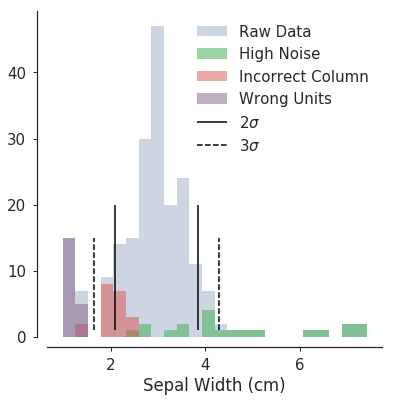

In [6]:
# Plot data with trimmed statistics
fig, axs = plt.subplots(figsize=(6, 6))

# Compute trimmed statistics
tmu = stats.tmean(x, (mu - sig, mu + sig))
tsig = stats.tstd(x, (mu - sig, mu + sig))

# Compute and display two-sigma errors
xl = [(tmu - 2.0 * tsig), (tmu + 2.0 * tsig)]
axs.vlines(xl, ymax = 20, ymin = 1, linestyle='-', \
           lw=2, alpha = 0.75, label='2$\sigma$')

# Compute and display three-sigma errors
xl = [(tmu - 3.0 * tsig), (tmu + 3.0 * tsig)]
axs.vlines(xl, ymax = 15, ymin = 1, linestyle='--',\
           lw=2, alpha = 0.75, label='3$\sigma$')

# Generate figure of data and outliers
hist_oned(x, 'Sepal Width (cm)', axs)

axs.legend(loc='best') ;

-----

To this point, we have visually explored outlier detection in one-dimension. Often, however, outlier detection can be more easily performed by exploring the data in higher dimensions, since the outliers are more likely to not follow the distributions of each feature. We now explore the Iris data in two-dimensions, by looking at both the _Sepal Width_ and the _Sepal Length_ feature. In the example below, we intentionally complicate the issue by ensuring the the data are outliers in both dimensions. Often this would not be the case, because many types of outliers would be unlikely to affect each feature in the identical manner.

In the first Code cell below, we construct the _Sepal Length_ one-dimensional data to match the _Sepal Width_ data. Specifically, we ensure the new feature matches the three types of outliers we previously constructed for the _Sepal Width_ feature. Next, we plot the _Sepal Length_ one-dimensional distribution, which more clearly separates out the data with incorrect units. Finally, in the second Code cell, we display the bivariate distribution of _Sepal Width_ and _Sepal Length_, which visually indicates the normally-distributed data, along with the different types of outliers. From this two-dimensional distribution, we see that some outliers can be removed by standard statistical techniques, however, more sophisticated machine learning techniques will likely be required (in higher dimensions) to eliminate most of these outlier points.

-----

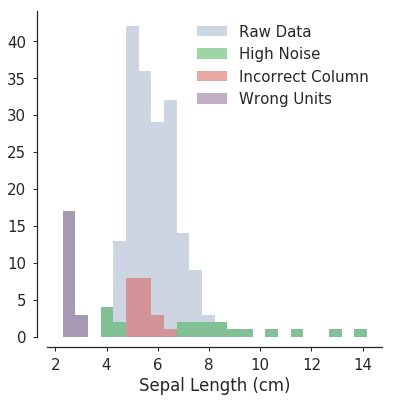

In [7]:
# Generate outlier data
data = iris['Sepal Length']
mu = np.mean(data)
sig = np.std(data)

# Add extreme outliers
y = np.append(data, (mu - 2.0 * sig) * uniform.rvs(0.9, 1.1, size=10))
y = np.append(y, (mu + 2.0 * sig) * uniform.rvs(0.9, 1.1, size=10))

# Add transposed feature outliers
y = np.append(y, iris['Petal Length'][-20:], axis=0)

# Add incorrect unit outliers
y = np.append(y, iris['Sepal Length'][-20:]/2.54, axis=0)

# Plot the one dimensional data
fig, axs = plt.subplots(figsize=(6, 6))
hist_oned(y, 'Sepal Length (cm)', axs)

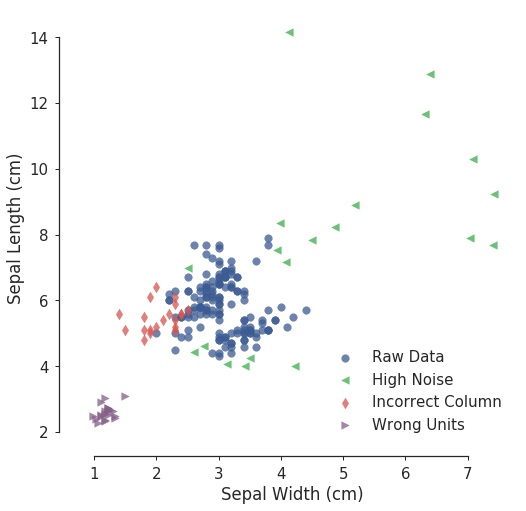

In [8]:
# Plot two-dimensional data distributions
fig, axs = plt.subplots(figsize=(8, 8))
   
# Plot normal data in blue
plt.scatter(x[:-60], y[:-60], 
            color=sns.xkcd_rgb['denim blue'], s=60, alpha=0.75, 
            label='Raw Data')
             
# Plot extreme outliers in green
plt.scatter(x[-60:-40], y[-60:-40], 
            color=sns.xkcd_rgb['medium green'], s=60, marker='<', alpha=0.75, 
            label='High Noise')
             
# Plot transposed data in red
plt.scatter(x[-40:-20], y[-40:-20], 
            color=sns.xkcd_rgb['pale red'], s=60, marker='d', alpha=0.75, 
            label='Incorrect Column')
             
# Plot wrong units in purple
plt.scatter(x[-20:], y[-20:], 
            color=sns.xkcd_rgb['dusty purple'], s=60, marker='>', alpha=0.75,
            label='Wrong Units')

axs.legend(loc=4)
axs.set_xlabel('Sepal Width (cm)')
axs.set_ylabel('Sepal Length (cm)')
sns.despine(offset=10, trim=True)

-----

<font color='red' size = '5'> Student Exercise </font>

Earlier in this notebook, we used visualization and statistical techniques to identify outliers in one-dimensional data. By using the preceding Code cells, try to make the following changes to see if your ability to identify outliers is improved.

3. Try displaying two- and three-sigma errors in both dimensions on the two-dimensional plot above.
4. Try adding new outliers that only have one feature affected by one of the three types of outliers we discussed. For example, copy instance to the end of the new data array and transpose only one feature or change the units on only one feature. Is it easier or harder to identify outliers in this new data?
2. Change the two-dimensional plot to match the earlier two-dimensional visualization using KDE. Specifically perform KDE on the normal data and over-plot the outliers. Do you think they would be easier or harder to see with this type of approach? Is this a fair approach or not?

-----

## Ancillary Information

The following links are to additional documentation that you might find helpful in learning this material. Reading these web-accessible documents is completely optional.

4. A nice introduction on how to [calculate outliers][1]
1. An overview of data exploration that discusses [outlier detection][2] in detail, from the Analytics Vidyha website
2. Wikipedia provides a lengthy list of [statistical outlier detection][3] techniques
43. Article discussing [statistical removal][4] of outlier detection

-----

[1]: http://www.wikihow.com/Calculate-Outliers
[2]: https://www.analyticsvidhya.com/blog/2016/01/guide-data-exploration/
[3]: https://en.wikipedia.org/wiki/Outlier
[4]: http://www.kdnuggets.com/2017/02/removing-outliers-standard-deviation-python.html

**&copy; 2017: Robert J. Brunner at the University of Illinois.**

This notebook is released under the [Creative Commons license CC BY-NC-SA 4.0][ll]. Any reproduction, adaptation, distribution, dissemination or making available of this notebook for commercial use is not allowed unless authorized in writing by the copyright holder.

[ll]: https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode